In [4]:
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt                               
import os 
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
matplotlib.rcParams["figure.dpi"] = 150
from particle import PDGID

import sys
sys.path.append('/home/elizahoward/cmspix28-mc-sim/utils')

import delphesRootToPixelAvTrackList as utils

In [5]:
datadir = './Simulation_Output/'
flp = 0

In [6]:
truthbib = pd.DataFrame()
recon2Dbib = pd.DataFrame()
truthsig = pd.DataFrame()
recon2Dsig = pd.DataFrame()

for file in os.listdir(datadir):
    if "labels" in file:
        if "bib" in file: 
            truthbib = pd.concat([truthbib,pd.read_parquet(f"{datadir}{file}")])
            file = file.replace("labels","recon2D")
            recon2Dbib = pd.concat([recon2Dbib,pd.read_parquet(f"{datadir}{file}")])
        elif "sig" in file: 
            truthsig = pd.concat([truthsig,pd.read_parquet(f"{datadir}{file}")])
            file = file.replace("labels","recon2D")
            recon2Dsig = pd.concat([recon2Dsig,pd.read_parquet(f"{datadir}{file}")])
            
clustersSig = recon2Dsig.to_numpy().reshape(recon2Dsig.shape[0],13,21)
clustersBib = recon2Dbib.to_numpy().reshape(recon2Dbib.shape[0],13,21)

print(f"# of bib clusters: {len(truthbib)}\n# of sig clusters {len(truthsig)}")
print(f"Total # of clusters: {len(truthbib)+len(truthsig)}")

# of bib clusters: 34550
# of sig clusters 38446
Total # of clusters: 72996


In [7]:
theta = np.arctan(30/truthsig['z-global'])
truthsig['eta'] = -np.log(np.tan(theta/2))
theta = np.arctan(30/truthbib['z-global'])
truthbib['eta'] = -np.log(np.tan(theta/2))

/home/elizahoward/venv2/lib64/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/elizahoward/venv2/lib64/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
truthbib.head()

,x-entry,y-entry,z-entry,n_x,n_y,n_z,number_eh_pairs,y-local,z-global,pt,hit_time,PID,cotAlpha,cotBeta,y-midplane,x-midplane,adjusted_hit_time,adjusted_hit_time_30ps_gaussian,adjusted_hit_time_60ps_gaussian,eta
0,40.505558,-26.001774,50.0,-0.583680,0.134413,-0.279539,8869.0,6.575,0.150,0.00089,0.03954,11.0,2.088009,-0.480838,-26.001774,40.505558,-0.060530,-0.040478,-0.081648,0.005000
1,-67.655136,-12.937151,50.0,0.540181,-0.245591,-0.291171,6737.0,8.325,-3.725,0.00089,0.05469,11.0,-1.855202,0.843460,-12.937151,-67.655136,-0.046148,-0.046126,0.017120,NaN
2,-5.651377,-24.378716,50.0,0.383204,0.195033,-0.502003,9249.0,-3.500,-4.675,0.00089,0.05951,11.0,-0.763350,-0.388510,-24.378716,-5.651377,-0.041767,-0.062493,-0.063290,NaN
3,39.207451,25.495531,50.0,-0.372020,-0.371988,-0.400146,4261.0,6.225,-6.575,0.00089,0.07076,11.0,0.929711,0.929631,25.495531,39.207451,-0.031684,-0.049665,-0.050539,NaN
4,-34.091530,-18.051561,50.0,-0.009975,0.026324,-0.282658,3847.0,6.300,30.825,0.00099,1.74120,11.0,0.035290,-0.093130,-18.051561,-34.091530,1.597722,1.568997,1.625017,0.900686


In [9]:
truthbib['R'] = truthbib['pt']*5.36/(1.60217663*3.57)*1000 # [mm]

In [10]:
omega = 1.60217663e-19*(3.57)/9.1093837e-31
T = 2*np.pi/omega

In [11]:
print(f"Average radius of bib track: {truthbib['R'].mean()}, stdev: {truthbib['R'].std()}")

Average radius of bib track: 7.820440201994691, stdev: 4.888542725782268


In [12]:
truthbib['R'].min()*1000

18.74201048886963

In [13]:
cut = truthbib['R']*1000*2<162.5
len(truthbib['R'][cut])

19

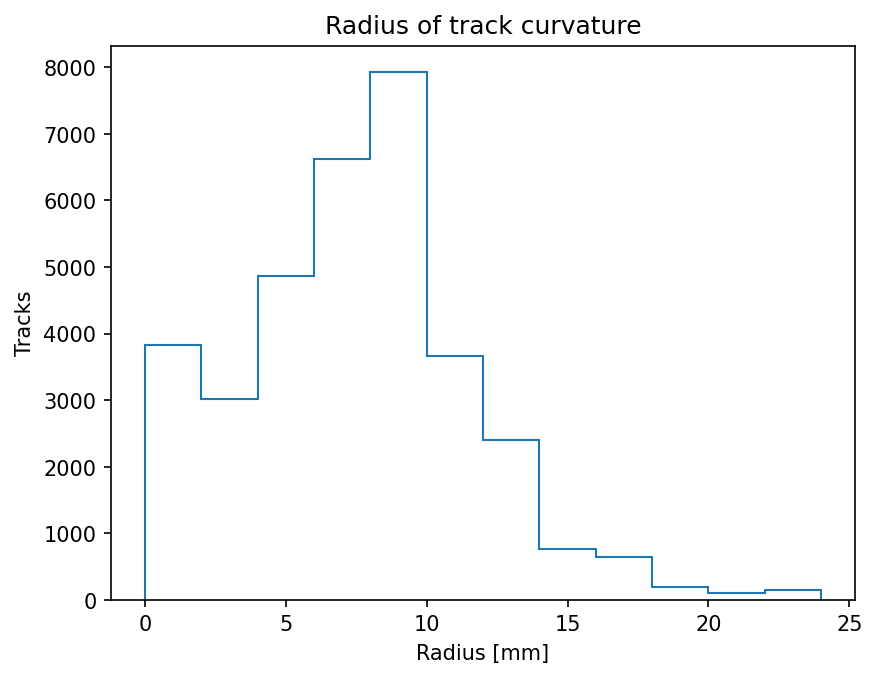

In [14]:
fig, ax = plt.subplots()
ax.hist(truthbib['R'], histtype='step', bins = np.arange(0,25,2))
ax.set_title("Radius of track curvature")
ax.set_xlabel("Radius [mm]")
ax.set_ylabel("Tracks")
plt.show()

In [15]:
def cutData(truth, recon, data, symbol, val, data2=None, symbol2=None, val2=None):
    if symbol == '>':
        cut = truth[data]>val
    elif symbol == '<':
        cut = truth[data]<val
    elif symbol == '>=':
        cut = truth[data]>=val
    elif symbol == '<=':
        cut = truth[data]<=val
    elif symbol == '==':
        cut = truth[data]==val
    
    if data2 != None:
        if symbol2 == '>':
            cut2 = truth[data2]>val2
        elif symbol2 == '<':
            cut2 = truth[data2]<val2
        elif symbol2 == '>=':
            cut2 = truth[data2]>=val2
        elif symbol2 == '<=':
            cut2 = truth[data2]<=val2
        elif symbol2 == '==':
            cut2 = truth[data2]==val2
        cut = cut & cut2

    truthCut = truth[cut] #.reset_index(inplace=True)
    reconCut = recon[cut] #.reset_index(inplace=True)

    truthCut.reset_index(inplace=True, drop=True)
    reconCut.reset_index(inplace=True, drop=True)

    clustersCut = reconCut.to_numpy().reshape(reconCut.shape[0],13,21)
    
    return truthCut, reconCut, clustersCut

In [16]:
truthHigh, recon2DHigh, clustersHigh = cutData(truthsig, recon2Dsig, 'pt', '>', 95)

truthLow, recon2DLow, clustersLow = cutData(truthsig, recon2Dsig, 'pt', '<', 5)

In [17]:
Q = []
for pid in truthLow['PID']:
    Q.append(PDGID(pid).charge)
truthLow.loc[:, "q"] =  Q

Q = []
for pid in truthHigh['PID']:
    Q.append(PDGID(pid).charge)
truthHigh.loc[:, "q"] =  Q

/tmp/ipykernel_1636962/111935735.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truthLow.loc[:, "q"] =  Q
/tmp/ipykernel_1636962/111935735.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truthHigh.loc[:, "q"] =  Q


In [18]:
# Seperate into positive and negative particles
truthLowPos, recon2DLowPos, clustersLowPos = cutData(truthLow, recon2DLow, 'q','>',0)
truthLowNeg, recon2DLowNeg, clustersLowNeg = cutData(truthLow, recon2DLow, 'q','<',0)

In [19]:
def getYProfiles(clusters):
    profiles = np.sum(clusters, axis = 2)
    #totalCharge = np.sum(profiles, axis = 1, keepdims=True)
    return profiles

def getAverageYProfile(clusters):
    profiles=getYProfiles(clusters)
    return np.mean(profiles, axis=0)

def getXProfiles(clusters):
    profiles = np.sum(clusters, axis = 1)
    #totalCharge = np.sum(profiles, axis = 1, keepdims=True)
    return profiles

def getAverageXProfile(clusters):
    profiles=getXProfiles(clusters)
    return np.mean(profiles, axis=0)

def getClusterYSizes(clusters):
    profiles=getYProfiles(clusters)
    bool_arr = profiles != 0
    return np.sum(bool_arr, axis = 1)

def getAverageClusterYSize(clusters):
    clusterSizes = getClusterYSizes(clusters)
    return np.mean(clusterSizes)

def getClusterXSizes(clusters):
    profiles=getXProfiles(clusters)
    bool_arr = profiles != 0
    return np.sum(bool_arr, axis = 1)

def getAverageClusterXSize(clusters):
    clusterSizes = getClusterXSizes(clusters)
    return np.mean(clusterSizes)

In [20]:
def getAverageCluster(clusters):
    return np.mean(clusters,axis=0)

In [21]:
# Seperate into out by ylocal

truthLowPos1, recon2DLowPos1, clustersLowPos1 = cutData(truthLowPos, recon2DLowPos, 'y-local', '<', -2)

truthLowNeg1,recon2DLowNeg1, clustersLowNeg1 = cutData(truthLowNeg, recon2DLowNeg, 'y-local', '<', -2)

truthHigh1, recon2DHigh1, clustersHigh1 = cutData(truthHigh, recon2DHigh, 'y-local', '<', -2)

profileLowPos1 = getAverageYProfile(clustersLowPos1)
profileLowNeg1 = getAverageYProfile(clustersLowNeg1)
profileHigh1 = getAverageYProfile(clustersHigh1)

In [22]:
# Seperate into out by ylocal

truthLowPos2, recon2DLowPos2, clustersLowPos2 = cutData(truthLowPos, recon2DLowPos, 'y-local', '>', 0, 'y-local', '<', 2)

truthLowNeg2,recon2DLowNeg2, clustersLowNeg2 = cutData(truthLowNeg, recon2DLowNeg, 'y-local', '>', 0, 'y-local', '<', 2)

truthHigh2, recon2DHigh2, clustersHigh2 = cutData(truthHigh, recon2DHigh, 'y-local', '>', 0, 'y-local', '<', 2)

profileLowPos2 = getAverageYProfile(clustersLowPos2)
profileLowNeg2 = getAverageYProfile(clustersLowNeg2)
profileHigh2 = getAverageYProfile(clustersHigh2)

In [23]:
# Seperate into out by ylocal

truthLowPos3, recon2DLowPos3, clustersLowPos3 = cutData(truthLowPos, recon2DLowPos, 'y-local', '>', 6)

truthLowNeg3,recon2DLowNeg3, clustersLowNeg3 = cutData(truthLowNeg, recon2DLowNeg, 'y-local', '>', 6)

truthHigh3, recon2DHigh3, clustersHigh3 = cutData(truthHigh, recon2DHigh, 'y-local', '>', 6)

profileLowPos3 = getAverageYProfile(clustersLowPos3)
profileLowNeg3 = getAverageYProfile(clustersLowNeg3)
profileHigh3 = getAverageYProfile(clustersHigh3)

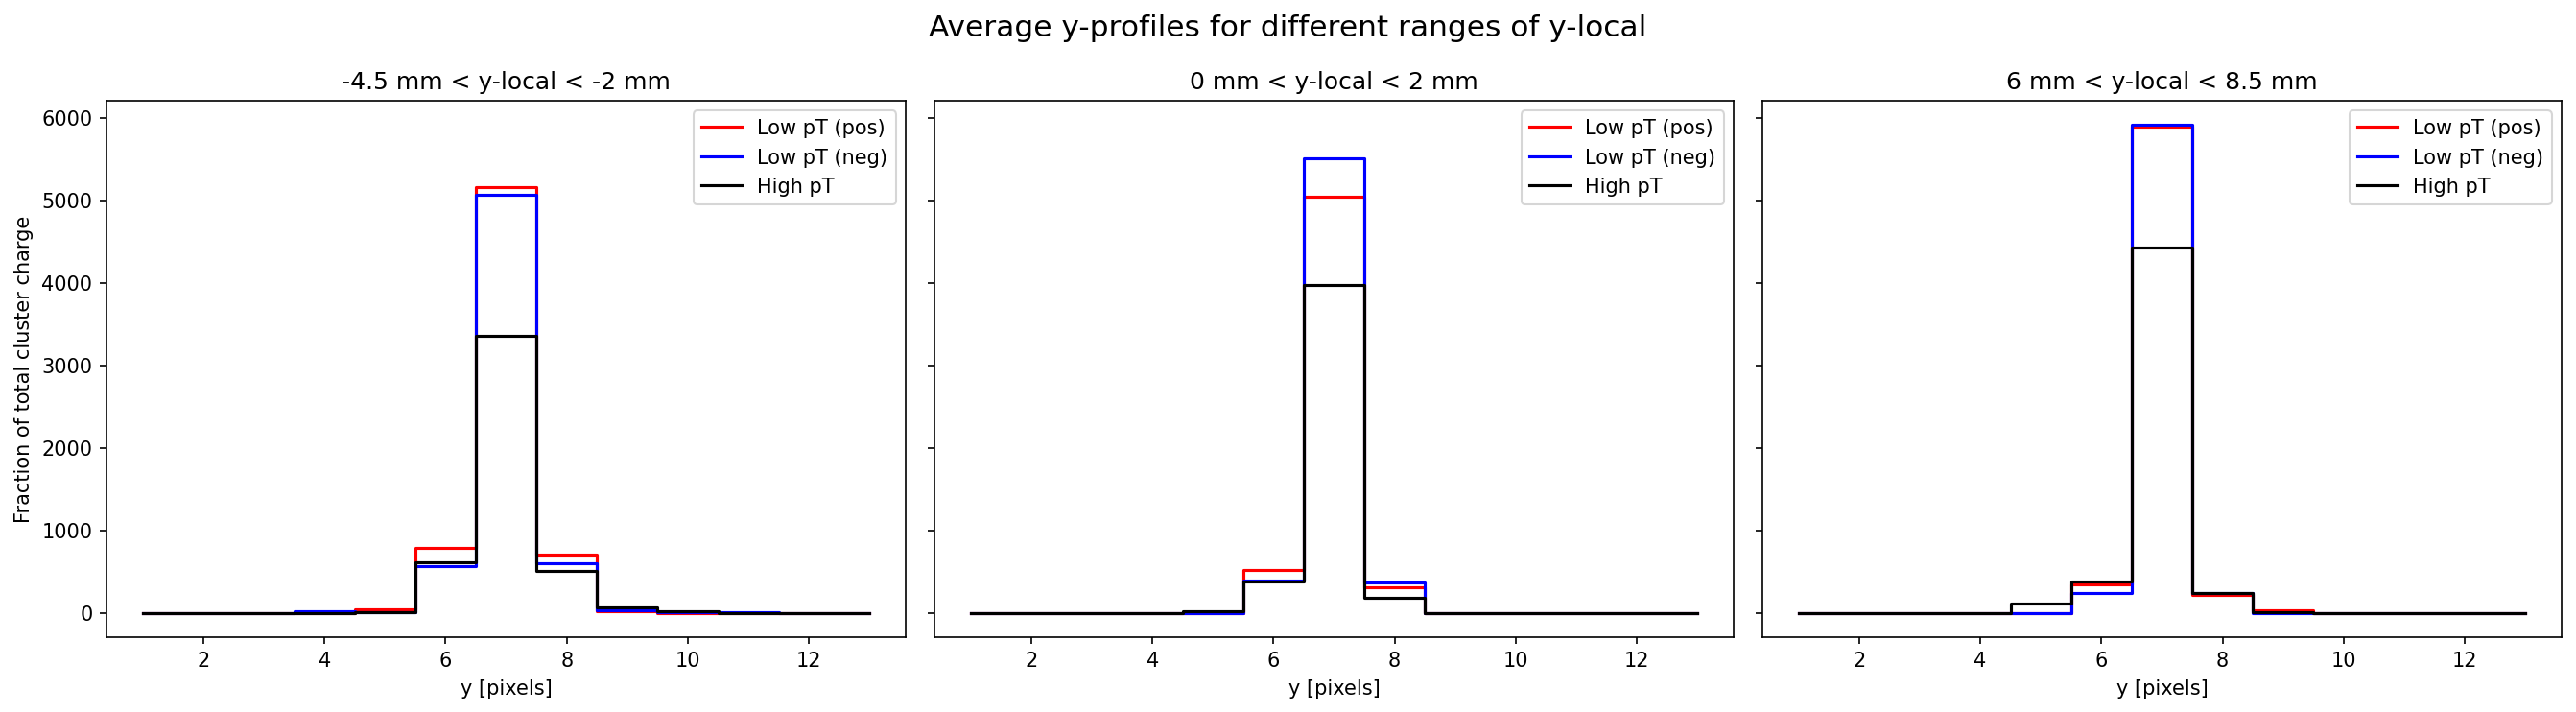

In [24]:
yaxis=np.arange(1,14,1)
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18,5))
ax[0].step(yaxis,profileLowPos1, where="mid", label="Low pT (pos)", c ='r')
ax[0].step(yaxis,profileLowNeg1, where="mid", label="Low pT (neg)", c='b')
ax[0].step(yaxis,profileHigh1, where="mid", label="High pT", c='k')
ax[0].legend()
ax[0].set_title("-4.5 mm < y-local < -2 mm")
ax[0].set_ylabel("Fraction of total cluster charge")
ax[0].set_xlabel("y [pixels]")

ax[1].step(yaxis,profileLowPos2, where="mid", label="Low pT (pos)", c ='r')
ax[1].step(yaxis,profileLowNeg2, where="mid", label="Low pT (neg)", c='b')
ax[1].step(yaxis,profileHigh2, where="mid", label="High pT", c='k')
ax[1].legend()
ax[1].set_title("0 mm < y-local < 2 mm")
ax[1].set_xlabel("y [pixels]")

ax[2].step(yaxis,profileLowPos3, where="mid", label="Low pT (pos)", c ='r')
ax[2].step(yaxis,profileLowNeg3, where="mid", label="Low pT (neg)", c='b')
ax[2].step(yaxis,profileHigh3, where="mid", label="High pT", c='k')
ax[2].legend()
ax[2].set_title("6 mm < y-local < 8.5 mm")
ax[2].set_xlabel("y [pixels]")

fig.suptitle('Average y-profiles for different ranges of y-local', fontsize=15)
plt.tight_layout()
plt.show()

In [25]:
truth1, recon2D1, clusters1 = cutData(truthsig, recon2Dsig, 'z-global', '<', 20)

truth2,recon2D2, clusters2 = cutData(truthsig, recon2Dsig, 'z-global', '>', 20, 'z-global', '<', 40)

truth3, recon2D3, clusters3 = cutData(truthsig, recon2Dsig, 'z-global', '>', 40)

profile1 = getAverageYProfile(clusters1)
profile2 = getAverageYProfile(clusters2)
profile3 = getAverageYProfile(clusters3)

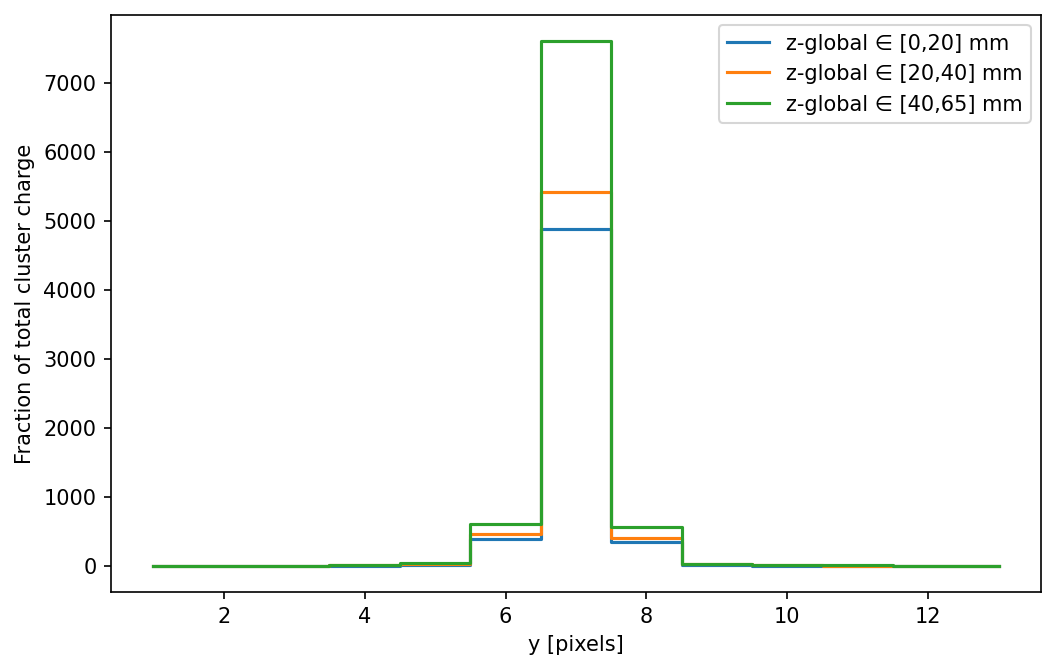

In [26]:
yaxis=np.arange(1,14,1)
fig, ax = plt.subplots(figsize=(8,5))
ax.step(yaxis,profile1, where="mid", label="z-global \u2208 [0,20] mm")
ax.step(yaxis,profile2, where="mid", label="z-global \u2208 [20,40] mm")
ax.step(yaxis,profile3, where="mid", label="z-global \u2208 [40,65] mm")
ax.legend()
ax.set_ylabel("Fraction of total cluster charge")
ax.set_xlabel("y [pixels]")
plt.show()

In [27]:
truth1, recon2D1, clusters1 = cutData(truthsig, recon2Dsig, 'y-local', '<', -2)

truth2,recon2D2, clusters2 = cutData(truthsig, recon2Dsig, 'y-local', '>', 0, 'y-local', '<', 2)

truth3, recon2D3, clusters3 = cutData(truthsig, recon2Dsig, 'y-local', '>', 6)

profile1 = getAverageYProfile(clusters1)
profile2 = getAverageYProfile(clusters2)
profile3 = getAverageYProfile(clusters3)

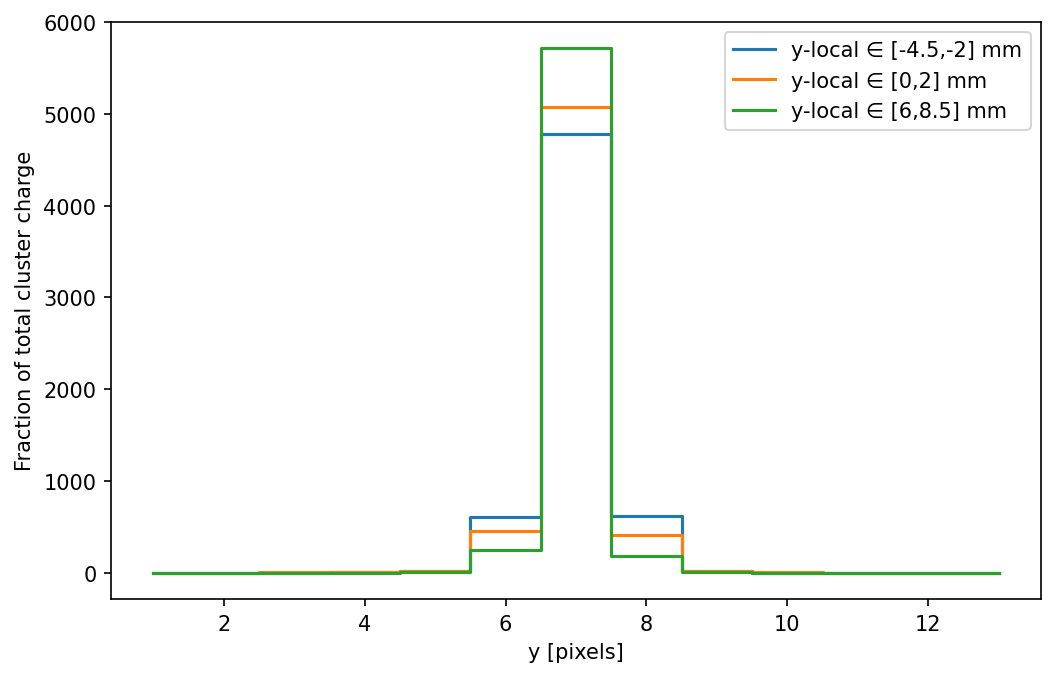

In [28]:
yaxis=np.arange(1,14,1)
fig, ax = plt.subplots(figsize=(8,5))
ax.step(yaxis,profile1, where="mid", label="y-local \u2208 [-4.5,-2] mm")
ax.step(yaxis,profile2, where="mid", label="y-local \u2208 [0,2] mm")
ax.step(yaxis,profile3, where="mid", label="y-local \u2208 [6,8.5] mm")
ax.legend()
ax.set_ylabel("Fraction of total cluster charge")
ax.set_xlabel("y [pixels]")
plt.show()

In [29]:
def clusterYSizeVsYlocal(truth, recon2D):
    clusterSize=[]
    intervals = np.arange(-5,9.5,1)
    for i in range(len(intervals)-1):
        cut1 = truth['y-local']>=intervals[i]
        cut2 = truth['y-local']<intervals[i+1]
        cut = cut1 & cut2
        tempRecon2D=recon2D[cut]
        clusters = tempRecon2D.to_numpy().reshape(tempRecon2D.shape[0],13,21)
        clusterSize.append(getAverageClusterYSize(clusters))
    return clusterSize

ylocals=np.arange(-4.5,9,1)

In [30]:
lowPosSize=clusterYSizeVsYlocal(truthLowPos, recon2DLowPos)
lowNegSize=clusterYSizeVsYlocal(truthLowNeg, recon2DLowNeg)
highSize=clusterYSizeVsYlocal(truthHigh, recon2DHigh)

In [31]:
len(lowPosSize)

14

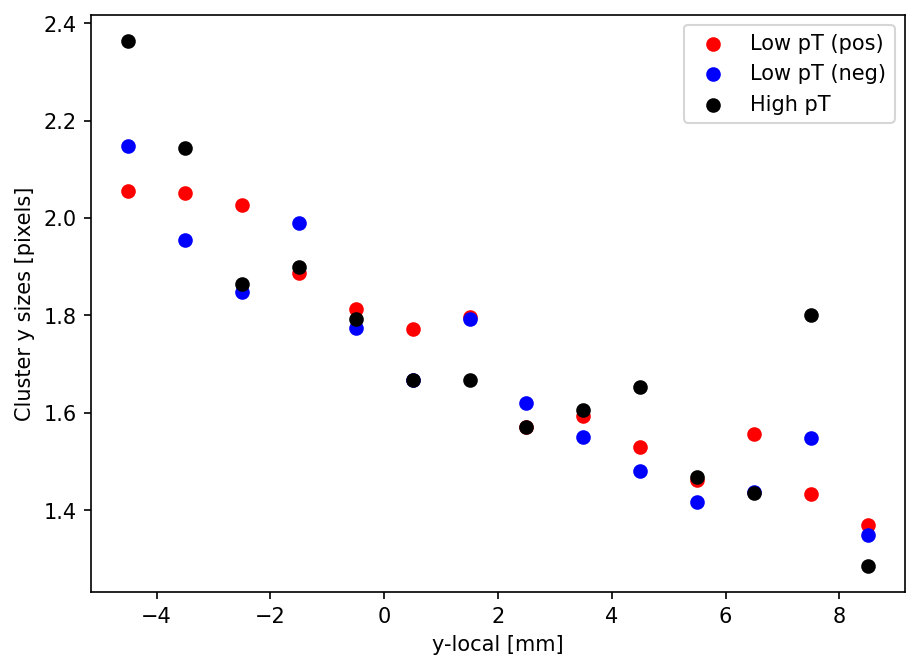

In [32]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(ylocals, lowPosSize, c='r', label="Low pT (pos)")
ax.scatter(ylocals, lowNegSize, c='b', label="Low pT (neg)")
ax.scatter(ylocals, highSize, c='k', label="High pT")
ax.set_xlabel("y-local [mm]")
ax.set_ylabel("Cluster y sizes [pixels]")
ax.legend()
plt.show()

In [33]:
profileXSig = getAverageXProfile(clustersSig)
profileXBib = getAverageXProfile(clustersBib)
xSizesSig = getClusterXSizes(clustersSig)
xSizesBib = getClusterXSizes(clustersBib)

profileYSig = getAverageYProfile(clustersSig)
profileYBib = getAverageYProfile(clustersBib)
ySizesSig = getClusterYSizes(clustersSig)
ySizesBib = getClusterYSizes(clustersBib)


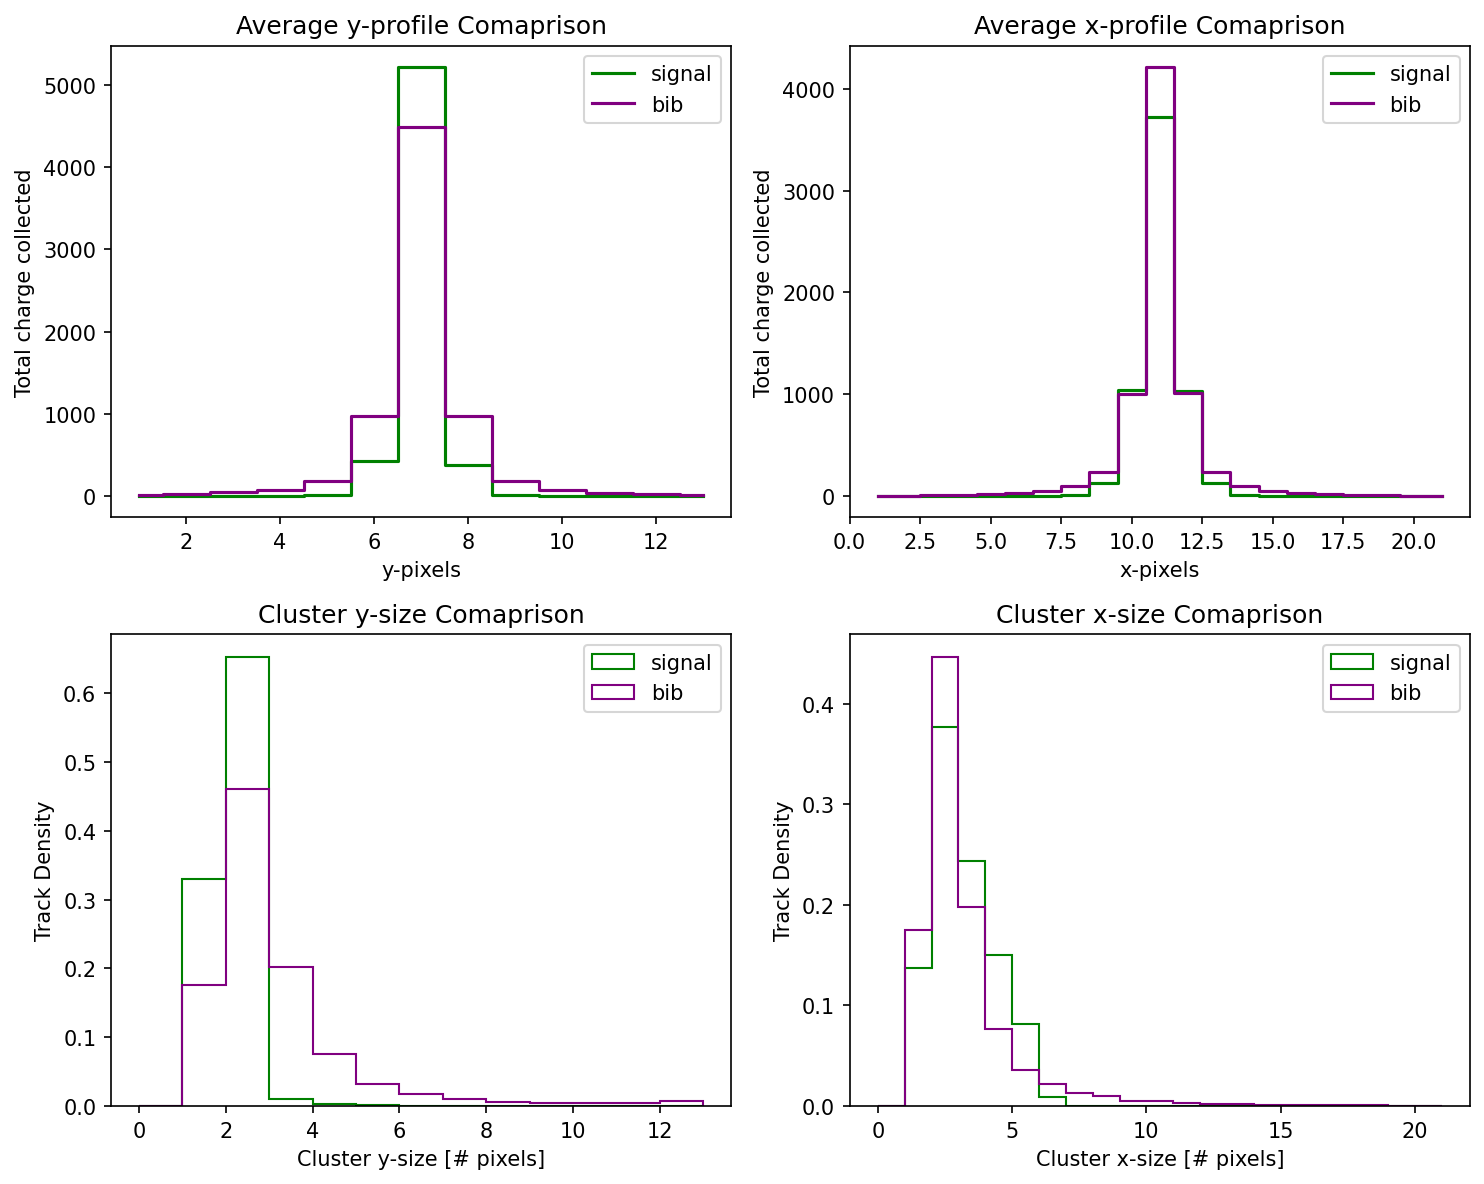

In [34]:
fig, ax=plt.subplots(ncols=2, nrows=2, figsize=(10,8))
xaxis = np.arange(1,22)
ax[0,0].step(yaxis,profileYSig, where="mid", label="signal", c ='g')
ax[0,0].step(yaxis,profileYBib, where="mid", label="bib", c ='purple')
ax[0,0].legend()
ax[0,0].set_xlabel("y-pixels")
ax[0,0].set_ylabel("Total charge collected")
ax[0,0].set_title("Average y-profile Comaprison")

ax[0,1].step(xaxis,profileXSig, where="mid", label="signal", c ='g')
ax[0,1].step(xaxis,profileXBib, where="mid", label="bib", c ='purple')
ax[0,1].legend()
ax[0,1].set_xlabel("x-pixels")
ax[0,1].set_ylabel("Total charge collected")
ax[0,1].set_title("Average x-profile Comaprison")

ax[1,0].hist(ySizesSig, bins=np.arange(0,14), histtype='step', density=True, label="signal", color ='g')
ax[1,0].hist(ySizesBib, bins=np.arange(0,14), histtype='step', density=True, label="bib", color ='purple')
ax[1,0].legend()
ax[1,0].set_xlabel("Cluster y-size [# pixels]")
ax[1,0].set_ylabel("Track Density")
ax[1,0].set_title("Cluster y-size Comaprison")

ax[1,1].hist(xSizesSig, bins=np.arange(0,22), histtype='step', density=True, label="signal", color ='g')
ax[1,1].hist(xSizesBib, bins=np.arange(0,22), histtype='step', density=True, label="bib", color ='purple')
ax[1,1].legend()
ax[1,1].set_xlabel("Cluster x-size [# pixels]")
ax[1,1].set_ylabel("Track Density")
ax[1,1].set_title("Cluster x-size Comaprison")

fig.tight_layout()

plt.show()

In [35]:
# Low pt, pos
ptLow = truthLow['pt'].mean() # Gev
ptHigh = truthHigh['pt'].mean() # GeV

q = 1

RLow = ptLow*5.36/(np.abs(q)*1.60217663*3.57)*1000
RHigh = ptHigh*5.36/(np.abs(q)*1.60217663*3.57)*1000
y0 = np.arange(-8.5, 5, .5)

betaLowPos = utils.getBeta(y0, RLow, q)
betaLowNeg = utils.getBeta(y0, RLow, -q)
betaHighPos = utils.getBeta(y0, RHigh, q)
betaHighNeg = utils.getBeta(y0, RHigh, -q)

if flp == 0:
    y0 *= -1
    betaLowPos += np.pi
    betaLowNeg += np.pi
    betaHighPos += np.pi
    betaHighNeg += np.pi

print(f"Max/Min Beta for high pt: {betaHighPos[len(betaHighPos)-1]} / {betaHighNeg[0]}")
print(f"Max/Min Beta for low pt: {betaLowPos[len(betaLowPos)-1]} / {betaLowNeg[0]}")

Max/Min Beta for high pt: 4.563332054498128 / 4.988657630900908
Max/Min Beta for low pt: 4.557948814026124 / 4.9941908768296805


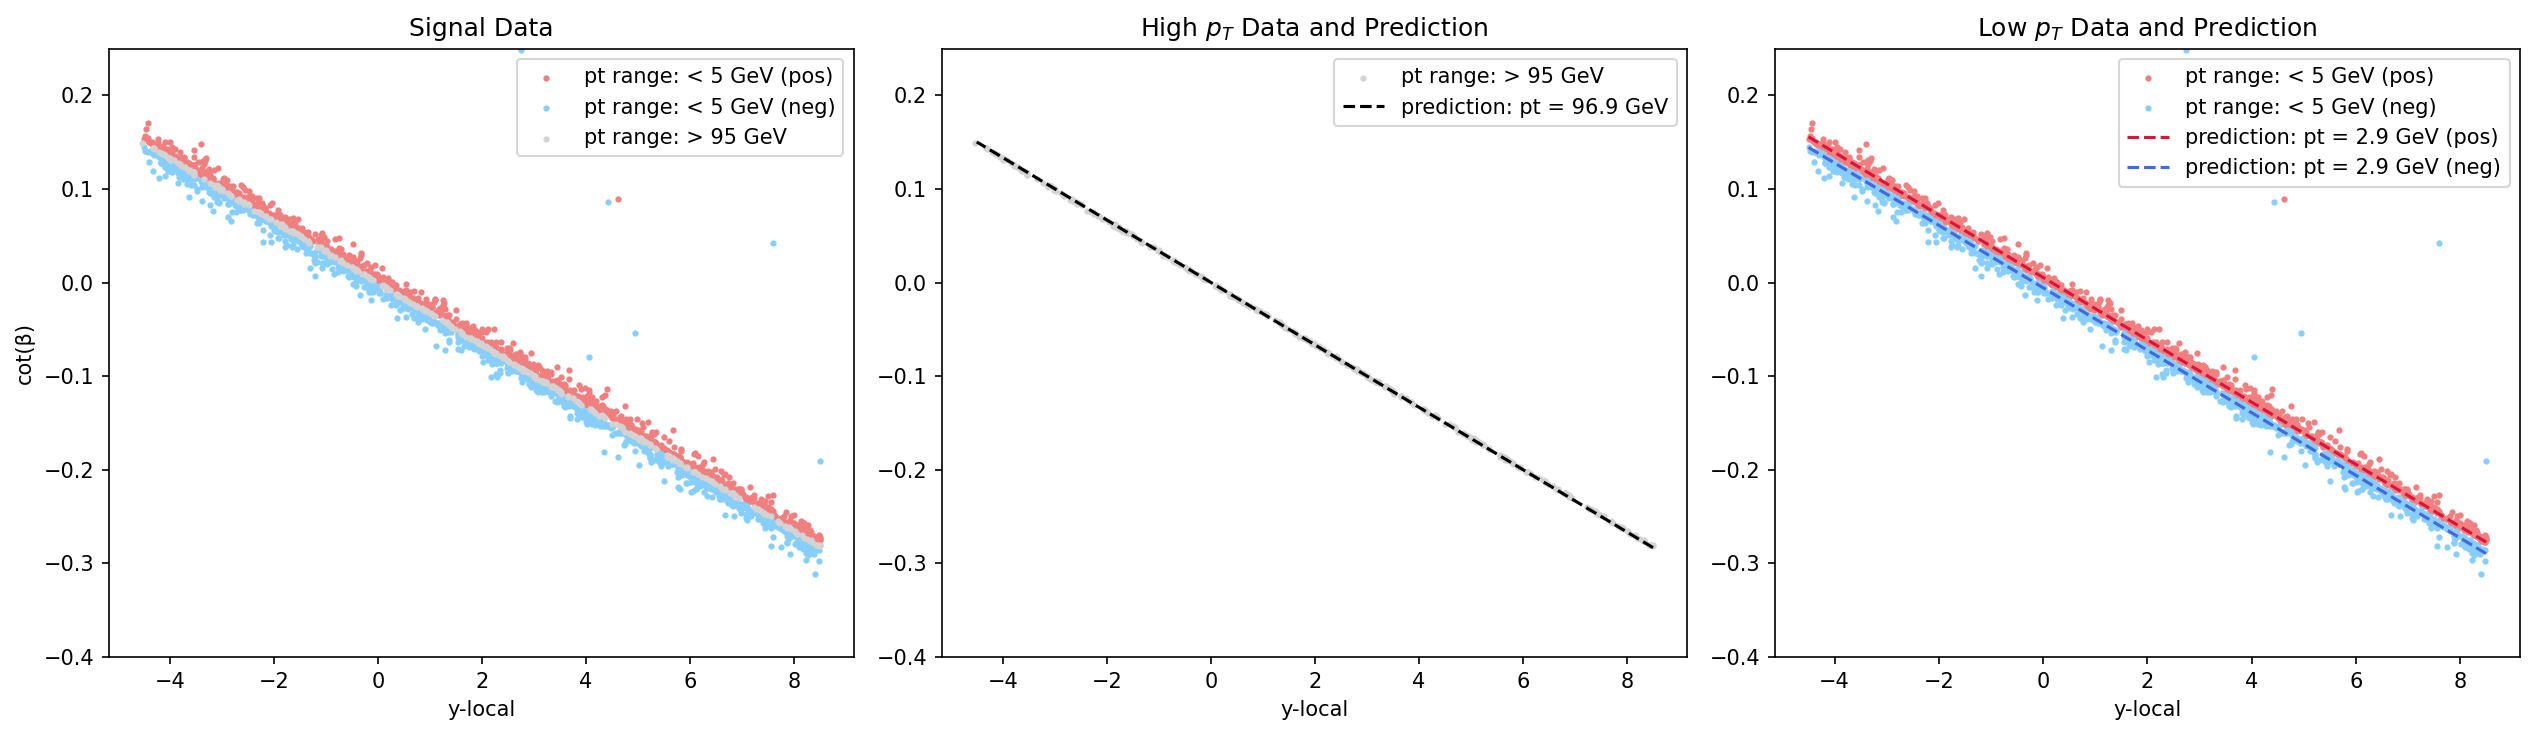

In [36]:
fig, ax = plt.subplots(ncols=3, figsize=(17,5))

ax[0].scatter(truthLowPos['y-local'], truthLowPos['cotBeta'], color='lightcoral',s=4, label='pt range: < 5 GeV (pos)')
ax[0].scatter(truthLowNeg['y-local'], truthLowNeg['cotBeta'], color='lightskyblue', s=4, label='pt range: < 5 GeV (neg)')
ax[0].scatter(truthHigh['y-local'], truthHigh['cotBeta'], color='lightgrey', s=4, label='pt range: > 95 GeV')
ax[0].set_ylim(-.4, .25)
ax[0].legend()
ax[0].set_ylabel(f'cot(\u03B2)')
ax[0].set_xlabel('y-local')
ax[0].set_title("Signal Data")

ax[1].scatter(truthHigh['y-local'], truthHigh['cotBeta'], color='lightgrey', s=4, label='pt range: > 95 GeV')
ax[1].plot(y0, 1/np.tan(betaHighPos), color='k',linestyle = 'dashed',label=f'prediction: pt = {round(ptHigh,1)} GeV')
ax[1].legend()
ax[1].set_xlabel('y-local')
ax[1].set_title(r"High $p_T$ Data and Prediction")
ax[1].sharey(ax[0])

ax[2].scatter(truthLowPos['y-local'], truthLowPos['cotBeta'], color='lightcoral',s=4, label='pt range: < 5 GeV (pos)')
ax[2].scatter(truthLowNeg['y-local'], truthLowNeg['cotBeta'], color='lightskyblue', s=4, label='pt range: < 5 GeV (neg)')
ax[2].plot(y0, 1/np.tan(betaLowPos), color='crimson',linestyle = 'dashed',label=f'prediction: pt = {round(ptLow,1)} GeV (pos)')
ax[2].plot(y0, 1/np.tan(betaLowNeg), color='royalblue',linestyle = 'dashed',label=f'prediction: pt = {round(ptLow,1)} GeV (neg)')
ax[2].legend()
ax[2].set_xlabel('y-local')
ax[2].set_title(r"Low $p_T$ Data and Prediction")
ax[2].sharey(ax[0])

fig.tight_layout()
plt.show()

In [37]:
def getClusterNPixels(clusters):
    clusters = clusters.to_numpy().reshape(clusters.shape[0],13,21)
    bool_arr = clusters != 0
    return np.sum(np.sum(bool_arr,axis=2),axis=1)

nPixelsbib = getClusterNPixels(recon2Dbib)
nPixelssig = getClusterNPixels(recon2Dsig)

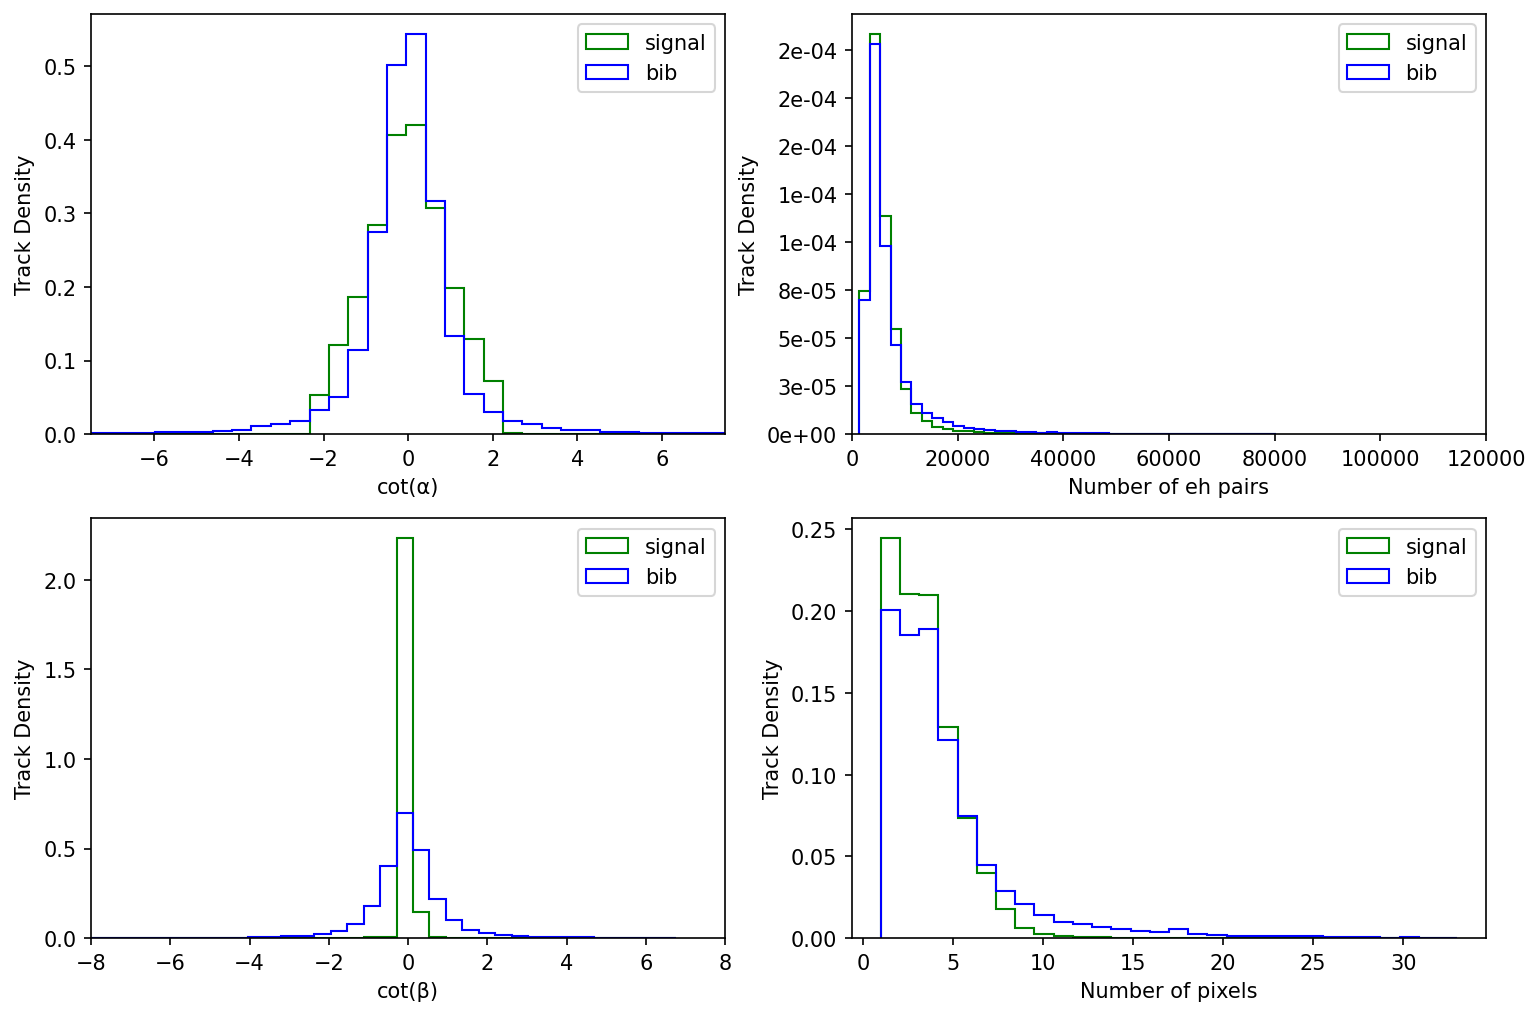

In [38]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(12,8))

n, bins, patches = ax[0,0].hist(truthsig['cotAlpha'],bins=40,histtype='step',color='g',align='mid',density=True,label="signal")
ax[0,0].hist(truthbib['cotAlpha'],bins=bins,histtype='step',color='b',align='mid',density=True,label="bib")
ax[0,0].set_xlabel(f'cot(\u03B1)')
ax[0,0].set_ylabel('Track Density')
ax[0,0].set_xlim(-7.5,7.5)
ax[0,0].legend()

n, bins, patches = ax[1,0].hist(truthsig['cotBeta'],bins=40,histtype='step',color='g',align='mid',density=True,label="signal")
ax[1,0].hist(truthbib['cotBeta'],bins=bins,histtype='step',color='b',align='mid',density=True,label="bib")
ax[1,0].set_xlabel(f'cot(\u03B2)')
ax[1,0].set_ylabel('Track Density')
ax[1,0].set_xlim(-8,8)
ax[1,0].legend()

n, bins, patches = ax[0,1].hist(truthsig['number_eh_pairs'],bins=40,histtype='step',color='g',align='mid',density=True,label="signal")
ax[0,1].hist(truthbib['number_eh_pairs'],bins=bins,histtype='step',color='b',align='mid',density=True,label="bib")
ax[0,1].set_xlabel('Number of eh pairs')
ax[0,1].set_ylabel('Track Density')
ax[0,1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0e}'.format(x)))
ax[0,1].set_xlim(0,120000)
ax[0,1].legend()

n, bins, patches = ax[1,1].hist(nPixelssig,bins=30,histtype='step',color='g',align='mid',density=True,label="signal")
ax[1,1].hist(nPixelsbib,bins=bins,histtype='step',color='b',align='mid',density=True,label="bib")
ax[1,1].set_xlabel('Number of pixels')
ax[1,1].set_ylabel('Track Density')
ax[1,1].legend()

plt.show()

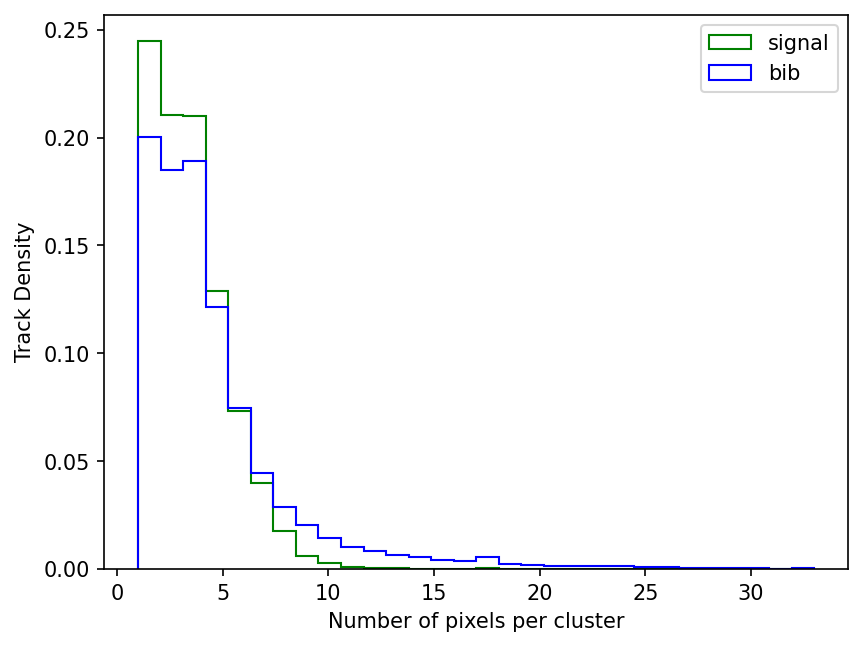

In [39]:
n, bins, patches = plt.hist(nPixelssig,bins=30,histtype='step',color='g',align='mid',density=True,label="signal")
plt.hist(nPixelsbib,bins=bins,histtype='step',color='b',align='mid',density=True,label="bib")
plt.xlabel('Number of pixels per cluster')
plt.ylabel('Track Density')
plt.legend()
plt.show()

In [40]:
cmap = mcolors.LinearSegmentedColormap.from_list("", ["white","red","darkred"])
def plotCluster(truth, recon2D, index):
    label = truth.iloc[index]
    cluster = recon2D.iloc[index].to_numpy().reshape(13,21)
    
    fig, ax = plt.subplots(figsize=(7,5),dpi=200)

    # Plot charge collected in each pixel
    datamin = 0 #cluster.min()
    datamax = 8000 #cluster.max()
    im = ax.imshow(cluster, vmin=datamin, vmax=datamax, cmap=cmap,interpolation='nearest')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.05)
    fig.colorbar(im, cax=cax, location='right',label='Number of eh pairs')
    ax.set_title("Charge collected by 4 ns")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.05)
    fig.colorbar(im, cax=cax, location='right',label='Number of eh pairs')

    # Draw grid on both
    ax.set_xlim(-0.5,20.5)
    ax.set_ylim(-0.5,12.5)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    ax.grid(which="minor", color="grey", linestyle='-', linewidth=0.5,snap=False)
    
    # Adjust truth values for coordinate system (the origin is in the center of the ROI)
    xentry = label['x-entry']/50 + 21/2
    yentry = label['y-entry']/12.5 + 13/2
    xmid = label['x-midplane']/50 + 21/2
    ymid = label['y-midplane']/12.5 + 13/2
    
    ax.plot(xentry,yentry, 'b.',label='entry point')
    ax.plot(xmid,ymid, 'g.',label='midplane point')
    ax.legend()
    
    plt.tight_layout(pad=3.5)
    fig.canvas.draw()

In [41]:
def plotSingleCluster(cluster):
    fig, ax = plt.subplots(figsize=(7,5),dpi=200)

    # Plot charge collected in each pixel
    datamin = cluster.min()
    datamax = cluster.max()
    im = ax.imshow(cluster, vmin=datamin, vmax=datamax, cmap=cmap, interpolation='nearest')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.05)
    fig.colorbar(im, cax=cax, location='right',label='Number of eh pairs')
    ax.set_title("Charge collected by 4 ns")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.05)
    fig.colorbar(im, cax=cax, location='right',label='Number of eh pairs')

    # Draw grid on both
    ax.set_xlim(-0.5,20.5)
    ax.set_ylim(-0.5,12.5)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    ax.grid(which="minor", color="grey", linestyle='-', linewidth=0.5,snap=False)
    
    plt.tight_layout(pad=3.5)
    fig.canvas.draw()

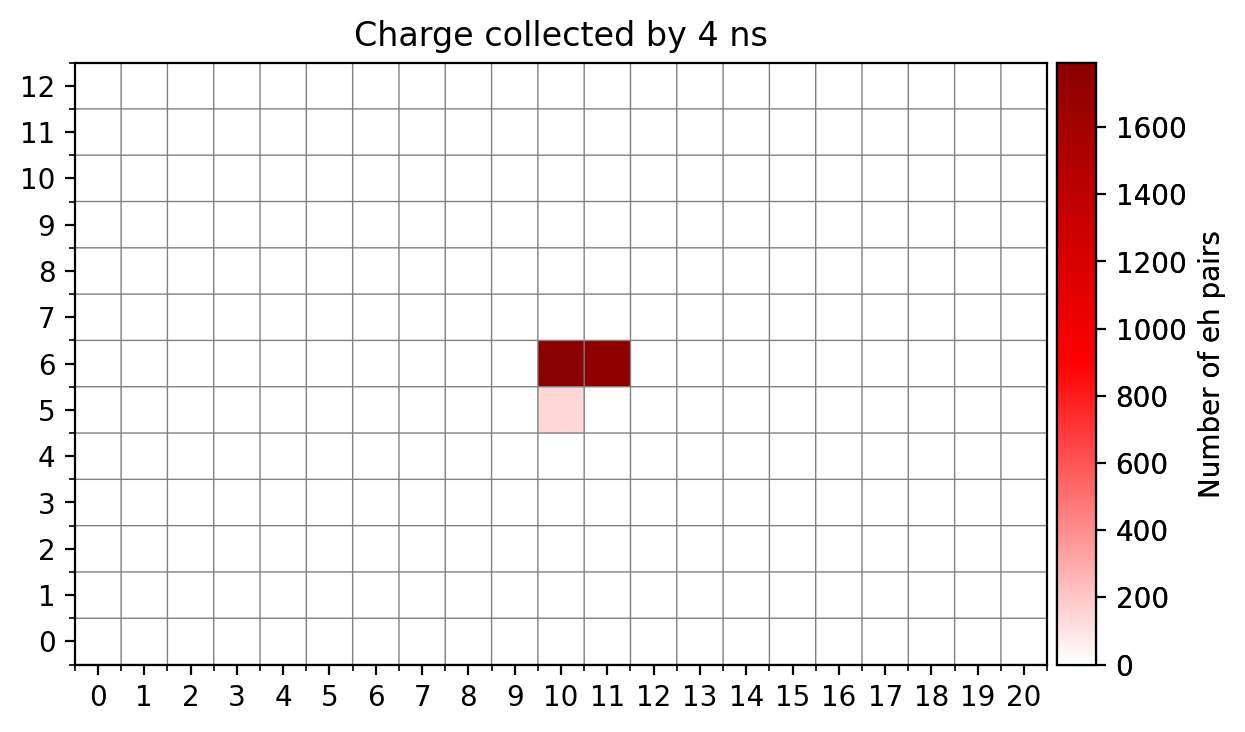

In [42]:
plotSingleCluster(clustersSig[4])

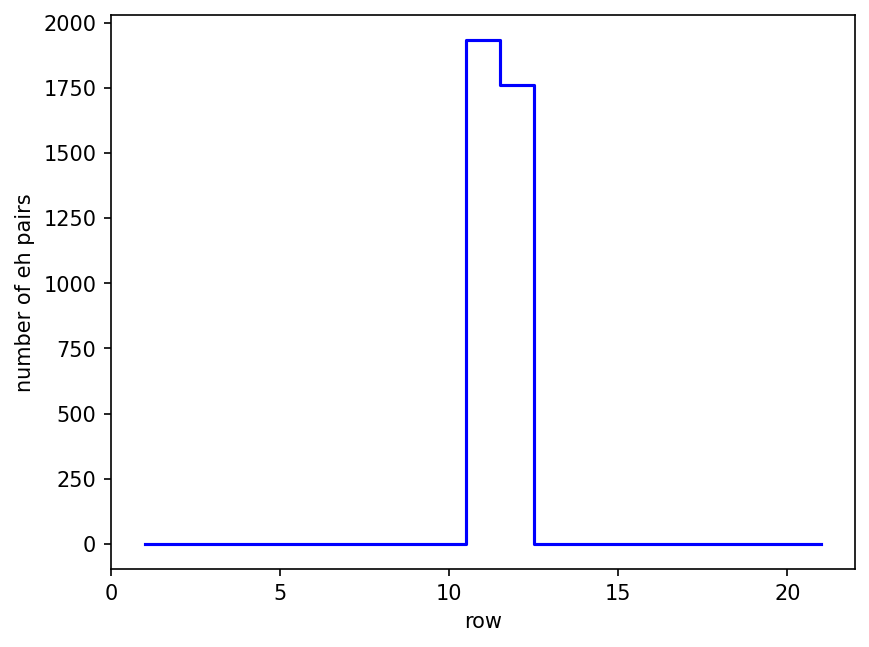

In [43]:
y_profile=getXProfiles(clustersSig)[4]
fig, ax = plt.subplots()
ax.step(xaxis,y_profile, where="mid", label="Low pT (pos)", c ='b')
ax.xaxis.get_major_locator().set_params(integer=True)
ax.set_xlabel('row')
ax.set_ylabel('number of eh pairs')
plt.show()

In [44]:
print(ySizesSig[4])
print(xSizesSig[4])

2
3


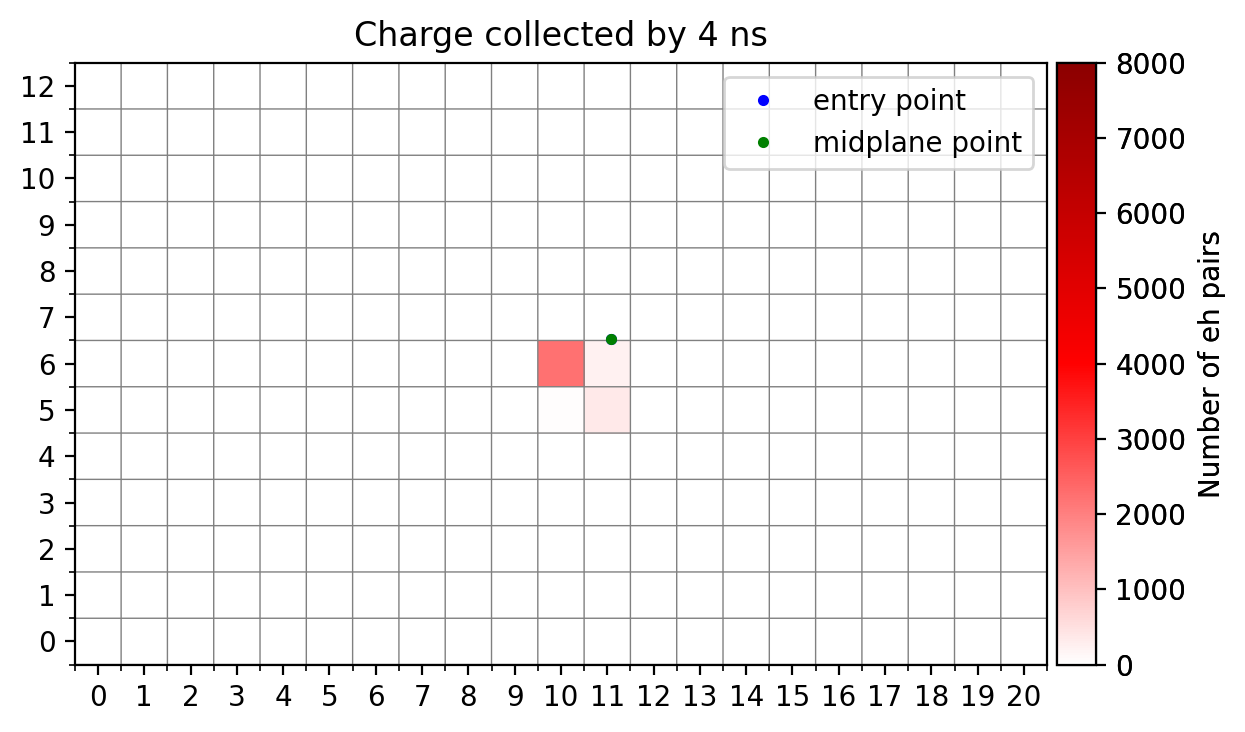

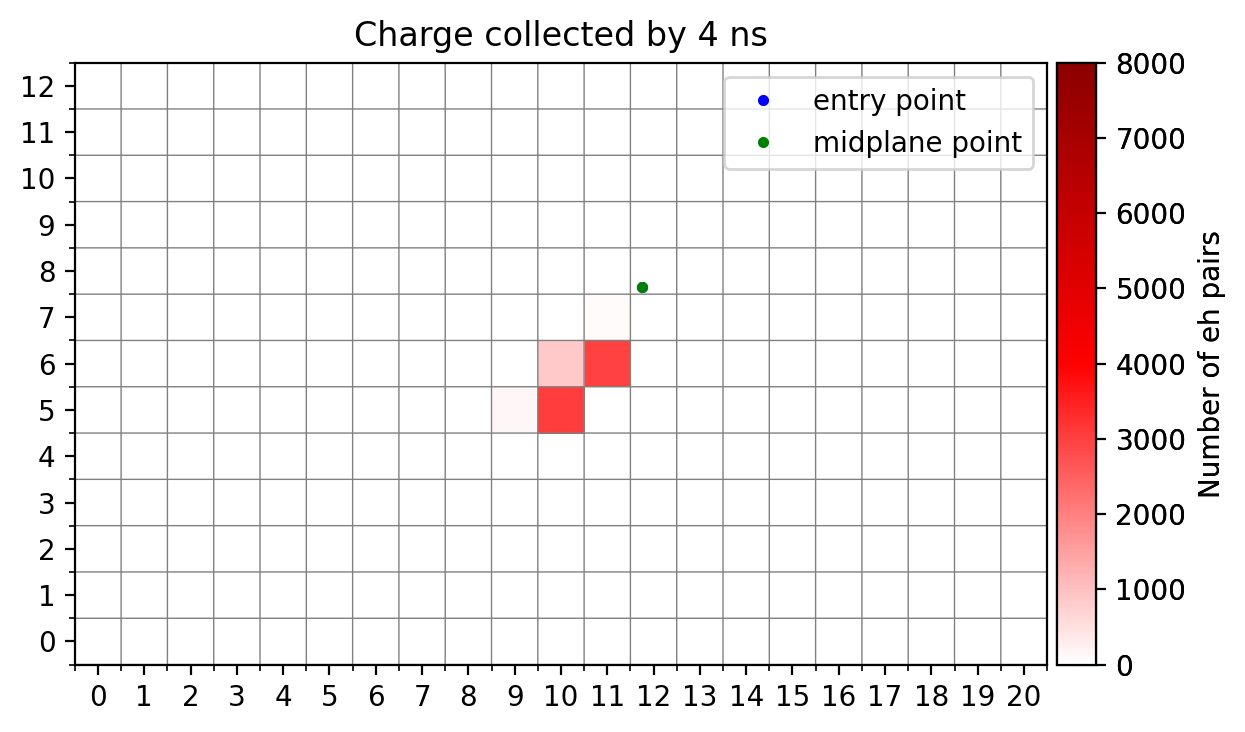

In [45]:
#avgCluster = getAverageCluster(clustersSig)
plotCluster(truthsig,recon2Dsig, 10)
plotCluster(truthbib,recon2Dbib, 100)
#plotSingleCluster(avgCluster)

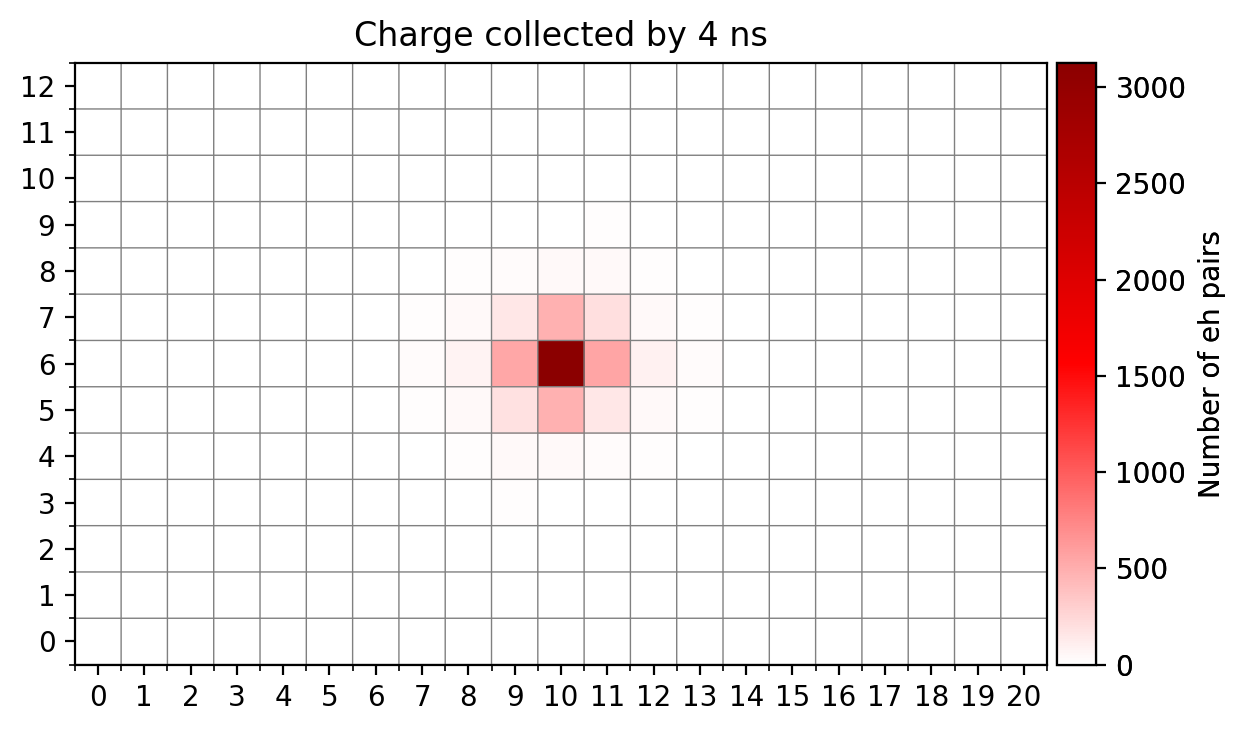

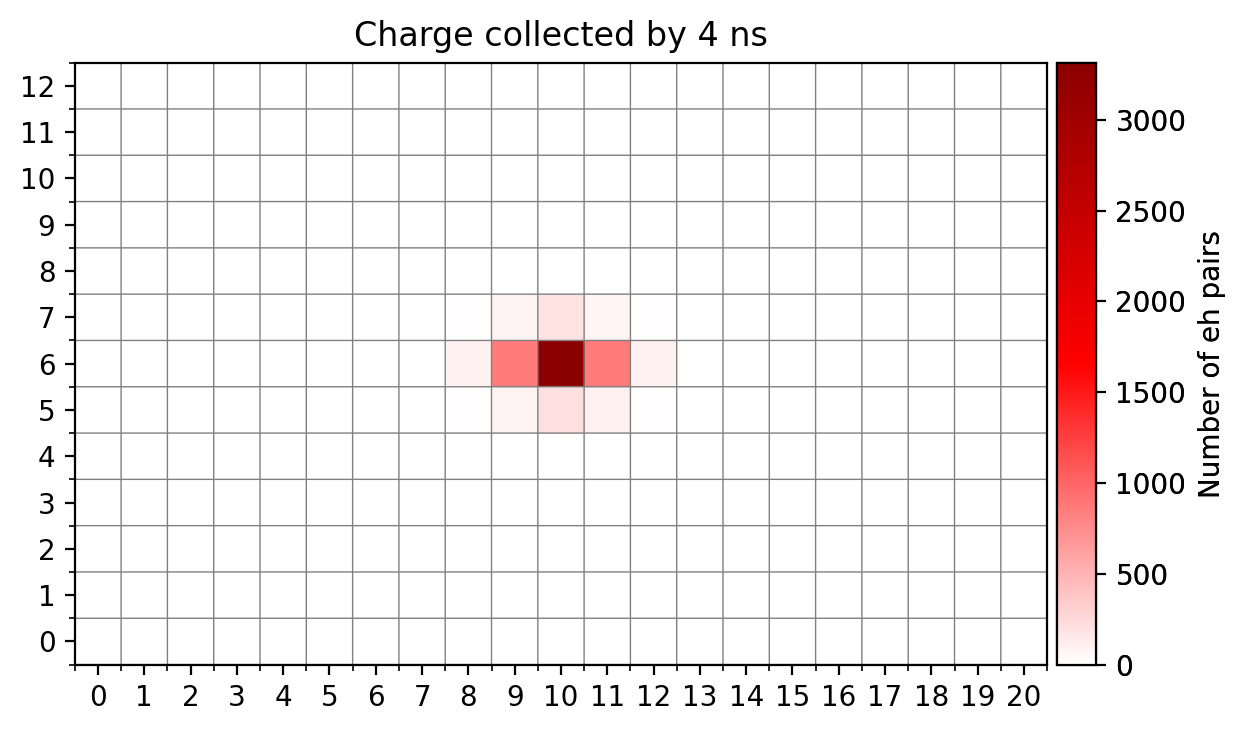

In [46]:
avgCluster = getAverageCluster(clustersBib)
plotSingleCluster(avgCluster)
avgCluster = getAverageCluster(clustersSig)
plotSingleCluster(avgCluster)

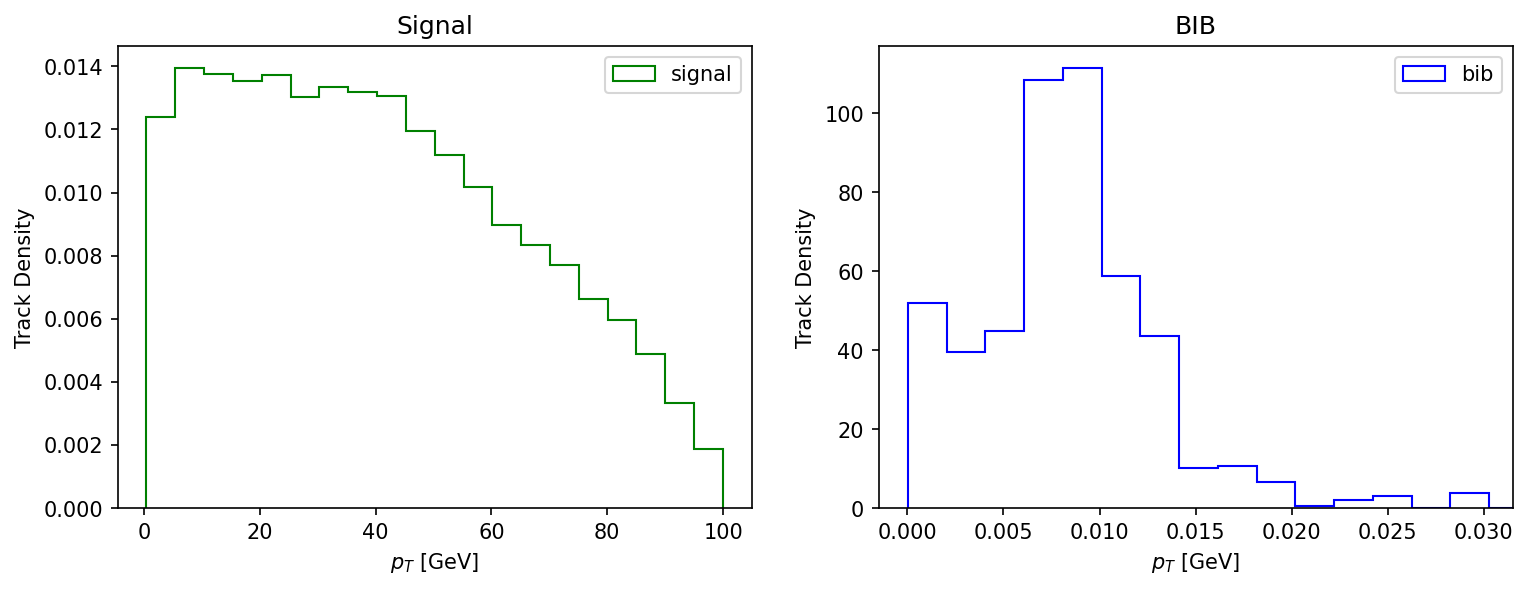

In [47]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
ax[0].hist(truthsig['pt'],bins=20,histtype='step',color='g',align='mid', density=True,label="signal")
ax[0].set_xlabel(r'$p_T$ [GeV]')
ax[0].set_ylabel('Track Density')
ax[0].set_title("Signal")
ax[0].legend()

ax[1].hist(truthbib['pt'],bins=150,histtype='step',color='b',align='mid', density=True,label="bib")
ax[1].set_xlabel(r'$p_T$ [GeV]')
ax[1].set_ylabel('Track Density')
ax[1].set_xlim(-.0015,.0315)
ax[1].set_title("BIB")
ax[1].legend()

plt.show()

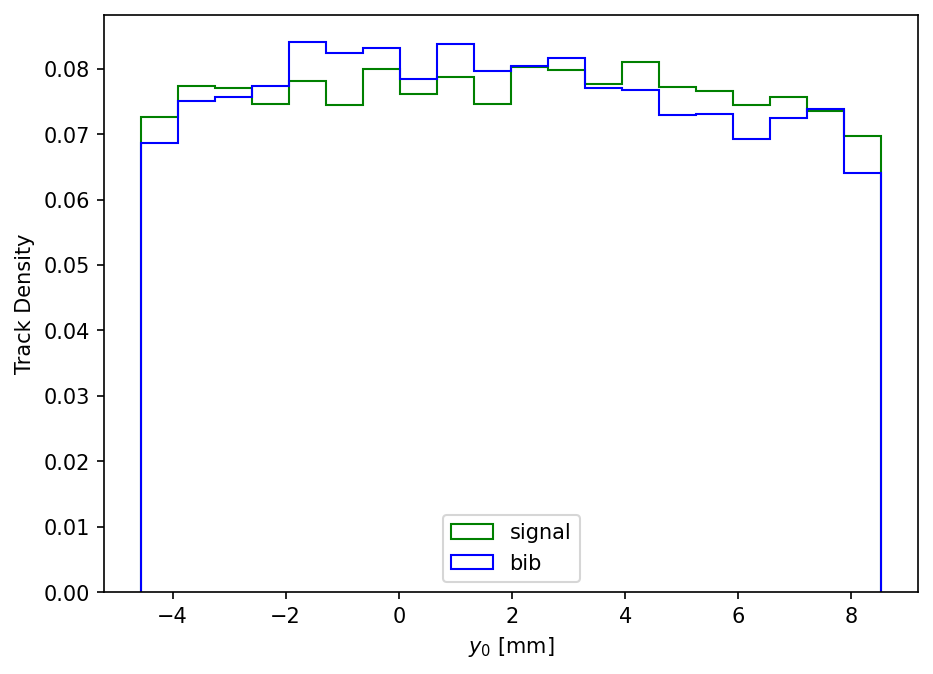

In [48]:
fig, ax = plt.subplots(figsize=(7,5))
n, bins, patches = ax.hist(truthsig['y-local'],bins=20,histtype='step',color='g',align='mid',density=True,label="signal")
ax.hist(truthbib['y-local'],bins=bins,histtype='step',color='b',align='mid',density=True,label="bib")
ax.set_xlabel(r'$y_0$ [mm]')
ax.set_ylabel('Track Density')
ax.legend(loc='lower center')
plt.show()

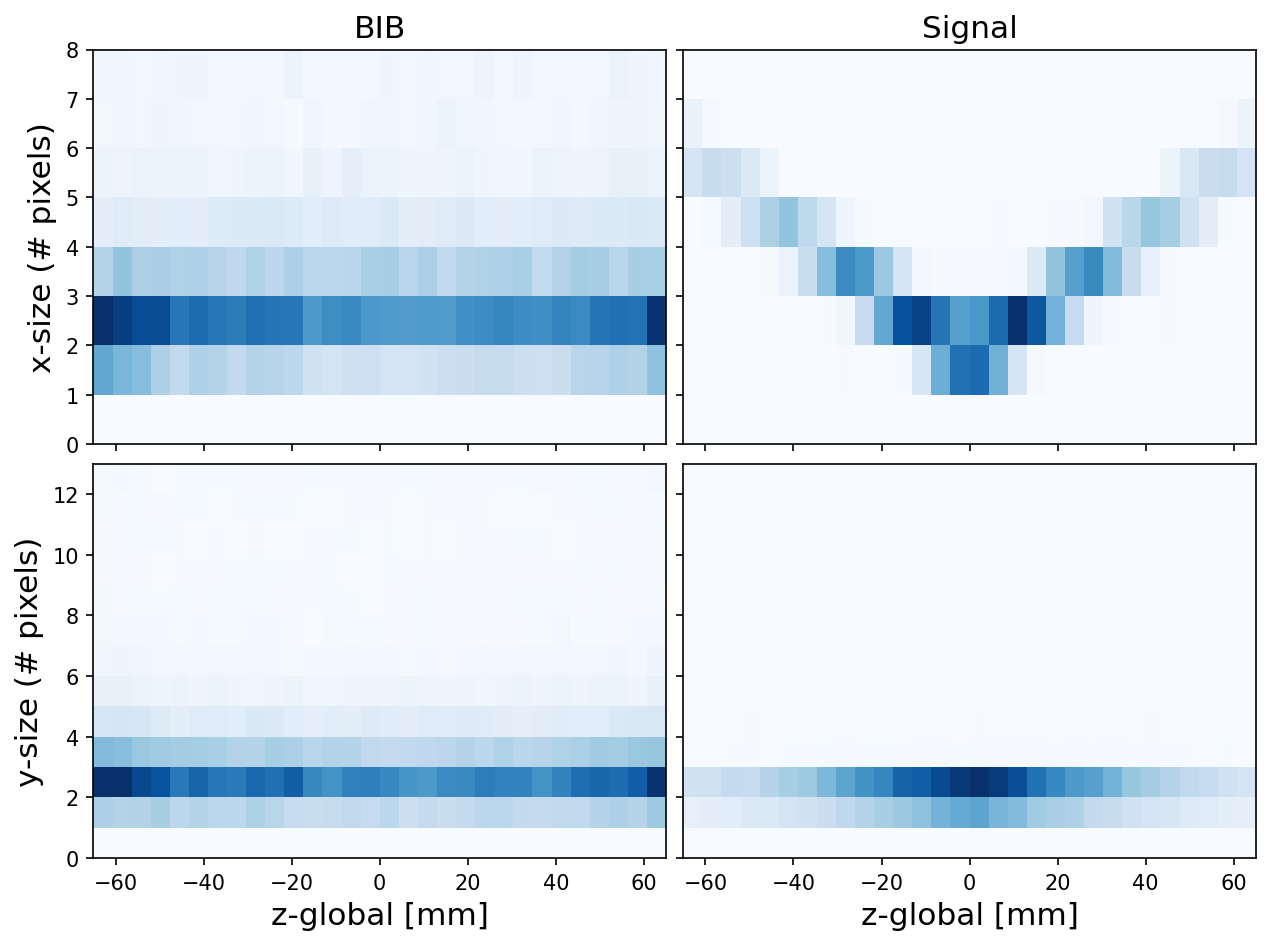

In [55]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', gridspec_kw={'hspace': 0.05, 'wspace': 0.03}, figsize=(10,7))

ax[0,0].hist2d(truthbib['z-global'], xSizesBib, bins=[30, np.arange(0,9,1)], cmap='Blues')
ax[0,0].set_ylabel('x-size (# pixels)', fontsize=15)
ax[0,0].set_title("BIB", fontsize=15)

ax[0,1].hist2d(truthsig['z-global'], xSizesSig, bins=[30, np.arange(0,9,1)], cmap='Blues')
ax[0,1].set_title("Signal", fontsize=15)

ax[1,0].hist2d(truthbib['z-global'], ySizesBib, bins=[30,np.arange(0,14,1)], cmap='Blues')
ax[1,0].set_xlabel('z-global [mm]', fontsize=15)
ax[1,0].set_ylabel('y-size (# pixels)', fontsize=15)

ax[1,1].hist2d(truthsig['z-global'], ySizesSig, bins=[30,np.arange(0,14,1)], cmap='Blues')
ax[1,1].set_xlabel('z-global [mm]', fontsize=15)

plt.show()

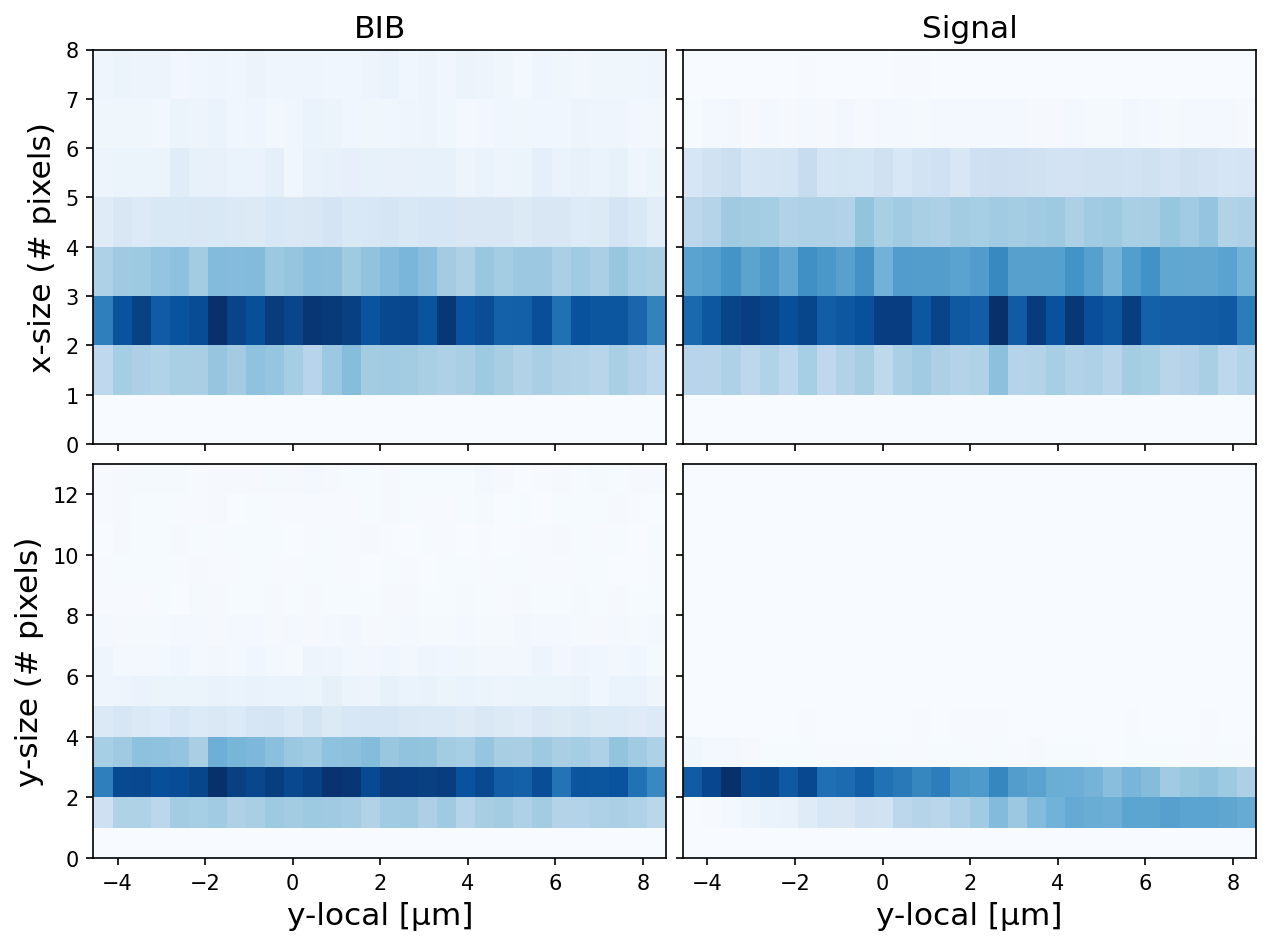

In [50]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', gridspec_kw={'hspace': 0.05, 'wspace': 0.03}, figsize=(10,7))

ax[0,0].hist2d(truthbib['y-local'], xSizesBib, bins=[30, np.arange(0,9,1)], cmap='Blues')
ax[0,0].set_ylabel('x-size (# pixels)', fontsize=15)
ax[0,0].set_title("BIB", fontsize=15)

ax[0,1].hist2d(truthsig['y-local'], xSizesSig, bins=[30, np.arange(0,9,1)], cmap='Blues')
ax[0,1].set_title("Signal", fontsize=15)

ax[1,0].hist2d(truthbib['y-local'], ySizesBib, bins=[30,np.arange(0,14,1)], cmap='Blues')
ax[1,0].set_xlabel('y-local [\u03bcm]', fontsize=15)
ax[1,0].set_ylabel('y-size (# pixels)', fontsize=15)

ax[1,1].hist2d(truthsig['y-local'], ySizesSig, bins=[30,np.arange(0,14,1)], cmap='Blues')
ax[1,1].set_xlabel('y-local [\u03bcm]', fontsize=15)

plt.show()

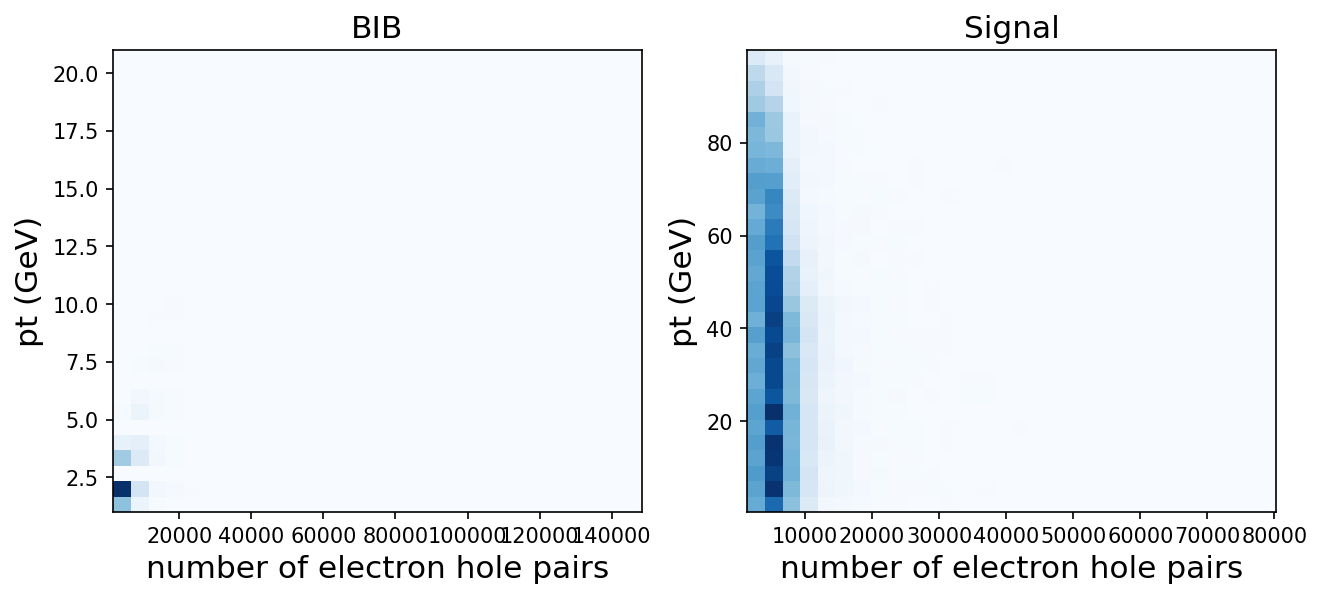

In [51]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(10,4))

ax[0].hist2d(truthbib['number_eh_pairs'], xSizesBib, bins=30, cmap='Blues')
ax[0].set_ylabel('pt (GeV)', fontsize=15)
ax[0].set_xlabel('number of electron hole pairs', fontsize=15)
ax[0].set_title("BIB", fontsize=15)

ax[1].hist2d(truthsig['number_eh_pairs'], truthsig['pt'], bins=30, cmap='Blues')
ax[1].set_title("Signal", fontsize=15)
ax[1].set_ylabel('pt (GeV)', fontsize=15)
ax[1].set_xlabel('number of electron hole pairs', fontsize=15)

plt.show()

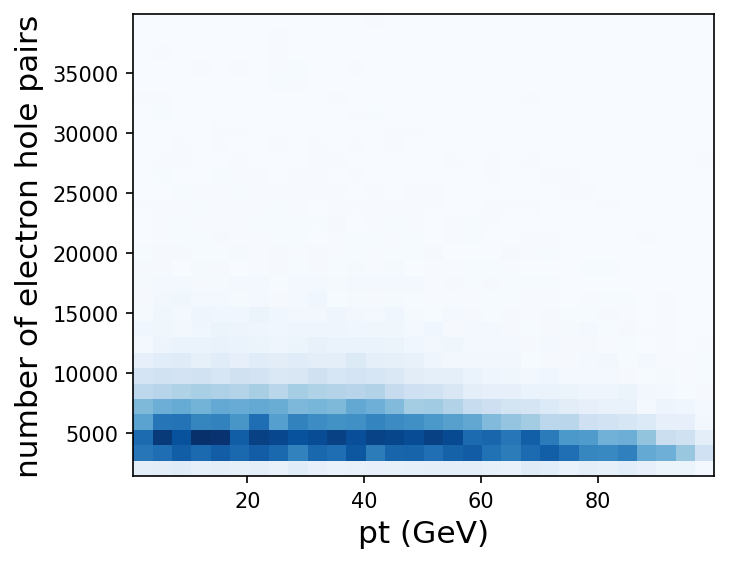

In [52]:
#eh_pairs = pd.concat((truthbib['number_eh_pairs'], truthsig['number_eh_pairs']))
#pt = pd.concat((truthbib['pt'],truthsig['pt']))
eh_pairs = truthsig['number_eh_pairs']
pt = truthsig['pt']

cut=eh_pairs<40000
eh_pairs = eh_pairs[cut]
pt = pt[cut]

#cut= pt<
#eh_pairs = eh_pairs[cut]
#pt = pt[cut]

fig, ax = plt.subplots(figsize=(5,4))

ax.hist2d(pt, eh_pairs, bins=30, cmap='Blues')
ax.set_xlabel('pt (GeV)', fontsize=15)
ax.set_ylabel('number of electron hole pairs', fontsize=15)



plt.show()

In [53]:
type(truthbib['number_eh_pairs'])

pandas.core.series.Series